# Image Segmentation Model - MONAI

##### Imports

In [1]:
import torch
import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    LoadImaged,
    RandSpatialCrop,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import CacheDataset, DataLoader, Dataset, ImageReader, MetaTensor
from monai.inferers import sliding_window_inference
from monai.transforms import Activations, AsDiscrete, KeepLargestConnectedComponent
from monai.visualize import plot_2d_or_3d_image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

from skimage.io import imread, imsave, imshow

from tqdm import tqdm

import datetime

##### Hyperparamters

In [2]:
batch_size = 4
num_workers = 4
learning_rate = 0.0005
num_epochs = 50
monai.utils.set_determinism(17)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [3]:
# class CellDataset(Dataset):
#     def __init__(self, data_dir, train=True):
#         self.data_dir = data_dir
#         self.image_dir = os.path.join(data_dir, 'image')
#         self.mask_dir = os.path.join(data_dir, 'mask')
#         self.image_files = os.listdir(self.image_dir)
#         self.mask_files = os.listdir(self.mask_dir)
#         self.transform_list = [
#             RandFlip(prob=1, spatial_axis=0),
#             RandFlip(prob=1, spatial_axis=1),
#             # RandRotate(prob=1, range_x=[1.57, 1.57]),
#             # RandRotate(prob=1, range_x=[4.71, 4.71])
#         ]
#         self.load_image = ImageReader()

#         if train:
#             self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
#                 self.image_files, self.mask_files, test_size=0.2, random_state=42)
#         else:
#             self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
#                 self.image_files, self.mask_files, test_size=0.2, random_state=42)
#             self.image_files, self.test_image_files = self.test_image_files, self.image_files
#             self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
#         self.temp_image_file = []
#         self.temp_mask_file = []
        
#         for image_path, mask_path in zip(self.image_files, self.mask_files):
#             image_path = os.path.join(self.image_dir, image_path)
#             mask_path = os.path.join(self.mask_dir, mask_path)
#             image_obj = self.load_image(image_path)
#             mask_obj = self.load_image.read(mask_path)
#             image = self.load_image.get_data(image_obj)[1]
#             mask = self.load_image.get_data(mask_obj)[1]
#             self.temp_image_file.append(image)
#             self.temp_mask_file.append(mask)
#             for transform in self.transform_list:
#                 self.temp_image_file.append(transform(image))
#                 self.temp_mask_file.append(transform(mask))
        
#         self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, index):

#         image = self.image_files[index].float()
#         mask = torch.where(self.mask_files[index].unsqueeze(0).float() == 0, 0.0, 1.0)

#         return image, mask


In [4]:
class CellDataset(Dataset):
    def __init__(self, data_dir, train=True):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform_list = [
            RandFlip(prob=1, spatial_axis=0),
            RandFlip(prob=1, spatial_axis=1),
            RandRotate(prob=1, range_y=[1.57, 1.57]),
            RandRotate(prob=1, range_y=[4.71, 4.71])
        ]

        if train:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
        else:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
            self.image_files, self.test_image_files = self.test_image_files, self.image_files
            self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = MetaTensor(imread(image_path))
            mask = MetaTensor(imread(mask_path)).unsqueeze(0)
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].float() == 0, 0.0, 1.0)

        return image, mask

In [5]:
DATA_DIR = r"D:\multiplexed-immunofluorescence-instance-segmentation\data\final"
train_dataset = CellDataset(DATA_DIR)
test_dataset = CellDataset(DATA_DIR, train=False)

In [6]:
train_dataset.__len__(), test_dataset.__len__()

(530, 135)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=torch.cuda.is_available())

In [8]:
len(train_loader), len(test_loader)

(133, 34)

##### Model Definition - UNet

In [9]:
in_channels = 8
out_channels = 1
model = UNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

##### Loss Function and Optimizer

In [10]:
criterion = DiceLoss(sigmoid=True, jaccard=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

##### Training Loop

In [11]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  2%|▏         | 1/50 [00:10<08:52, 10.86s/it]

Epoch 1/50, Train Loss: 0.4633, Test Loss: 0.4158


  4%|▍         | 2/50 [00:19<07:51,  9.83s/it]

Epoch 2/50, Train Loss: 0.4103, Test Loss: 0.3733


  6%|▌         | 3/50 [00:29<07:26,  9.51s/it]

Epoch 3/50, Train Loss: 0.3741, Test Loss: 0.3419


  8%|▊         | 4/50 [00:38<07:10,  9.35s/it]

Epoch 4/50, Train Loss: 0.3455, Test Loss: 0.3144


 10%|█         | 5/50 [00:47<06:57,  9.29s/it]

Epoch 5/50, Train Loss: 0.3227, Test Loss: 0.2975


 12%|█▏        | 6/50 [00:56<06:45,  9.22s/it]

Epoch 6/50, Train Loss: 0.3068, Test Loss: 0.2816


 14%|█▍        | 7/50 [01:05<06:34,  9.18s/it]

Epoch 7/50, Train Loss: 0.2920, Test Loss: 0.2730


 16%|█▌        | 8/50 [01:14<06:25,  9.17s/it]

Epoch 8/50, Train Loss: 0.2819, Test Loss: 0.2681


 18%|█▊        | 9/50 [01:23<06:15,  9.17s/it]

Epoch 9/50, Train Loss: 0.2712, Test Loss: 0.2578


 20%|██        | 10/50 [01:33<06:06,  9.16s/it]

Epoch 10/50, Train Loss: 0.2612, Test Loss: 0.2551


 22%|██▏       | 11/50 [01:42<05:57,  9.17s/it]

Epoch 11/50, Train Loss: 0.2503, Test Loss: 0.2532


 24%|██▍       | 12/50 [01:51<05:48,  9.17s/it]

Epoch 12/50, Train Loss: 0.2398, Test Loss: 0.2480


 26%|██▌       | 13/50 [02:00<05:40,  9.21s/it]

Epoch 13/50, Train Loss: 0.2314, Test Loss: 0.2454


 28%|██▊       | 14/50 [02:09<05:32,  9.23s/it]

Epoch 14/50, Train Loss: 0.2230, Test Loss: 0.2457


 30%|███       | 15/50 [02:19<05:23,  9.25s/it]

Epoch 15/50, Train Loss: 0.2138, Test Loss: 0.2436


 32%|███▏      | 16/50 [02:28<05:15,  9.27s/it]

Epoch 16/50, Train Loss: 0.2067, Test Loss: 0.2433


 34%|███▍      | 17/50 [02:37<05:06,  9.28s/it]

Epoch 17/50, Train Loss: 0.1999, Test Loss: 0.2432


 36%|███▌      | 18/50 [02:47<04:56,  9.26s/it]

Epoch 18/50, Train Loss: 0.1946, Test Loss: 0.2468


 38%|███▊      | 19/50 [02:56<04:47,  9.29s/it]

Epoch 19/50, Train Loss: 0.1904, Test Loss: 0.2414


 40%|████      | 20/50 [03:05<04:37,  9.26s/it]

Epoch 20/50, Train Loss: 0.1851, Test Loss: 0.2429


 42%|████▏     | 21/50 [03:14<04:28,  9.25s/it]

Epoch 21/50, Train Loss: 0.1804, Test Loss: 0.2423


 44%|████▍     | 22/50 [03:24<04:19,  9.26s/it]

Epoch 22/50, Train Loss: 0.1779, Test Loss: 0.2404


 46%|████▌     | 23/50 [03:33<04:09,  9.24s/it]

Epoch 23/50, Train Loss: 0.1745, Test Loss: 0.2383


 48%|████▊     | 24/50 [03:42<03:59,  9.23s/it]

Epoch 24/50, Train Loss: 0.1712, Test Loss: 0.2427


 50%|█████     | 25/50 [03:51<03:50,  9.20s/it]

Epoch 25/50, Train Loss: 0.1680, Test Loss: 0.2424


 52%|█████▏    | 26/50 [04:00<03:40,  9.20s/it]

Epoch 26/50, Train Loss: 0.1653, Test Loss: 0.2408


 54%|█████▍    | 27/50 [04:10<03:31,  9.20s/it]

Epoch 27/50, Train Loss: 0.1626, Test Loss: 0.2396


 56%|█████▌    | 28/50 [04:19<03:22,  9.19s/it]

Epoch 28/50, Train Loss: 0.1626, Test Loss: 0.2398


 58%|█████▊    | 29/50 [04:28<03:13,  9.20s/it]

Epoch 29/50, Train Loss: 0.1593, Test Loss: 0.2374


 60%|██████    | 30/50 [04:37<03:03,  9.18s/it]

Epoch 30/50, Train Loss: 0.1585, Test Loss: 0.2411


 62%|██████▏   | 31/50 [04:46<02:54,  9.19s/it]

Epoch 31/50, Train Loss: 0.1552, Test Loss: 0.2366


 64%|██████▍   | 32/50 [04:55<02:45,  9.17s/it]

Epoch 32/50, Train Loss: 0.1538, Test Loss: 0.2388


 66%|██████▌   | 33/50 [05:05<02:35,  9.16s/it]

Epoch 33/50, Train Loss: 0.1520, Test Loss: 0.2390


 68%|██████▊   | 34/50 [05:14<02:26,  9.17s/it]

Epoch 34/50, Train Loss: 0.1517, Test Loss: 0.2436


 70%|███████   | 35/50 [05:23<02:17,  9.18s/it]

Epoch 35/50, Train Loss: 0.1491, Test Loss: 0.2388


 72%|███████▏  | 36/50 [05:32<02:08,  9.18s/it]

Epoch 36/50, Train Loss: 0.1477, Test Loss: 0.2391


 74%|███████▍  | 37/50 [05:41<01:59,  9.18s/it]

Epoch 37/50, Train Loss: 0.1466, Test Loss: 0.2396


 76%|███████▌  | 38/50 [05:51<01:50,  9.19s/it]

Epoch 38/50, Train Loss: 0.1449, Test Loss: 0.2391


 78%|███████▊  | 39/50 [06:00<01:41,  9.22s/it]

Epoch 39/50, Train Loss: 0.1449, Test Loss: 0.2387


 80%|████████  | 40/50 [06:09<01:32,  9.21s/it]

Epoch 40/50, Train Loss: 0.1439, Test Loss: 0.2371


 82%|████████▏ | 41/50 [06:18<01:22,  9.21s/it]

Epoch 41/50, Train Loss: 0.1429, Test Loss: 0.2375


 84%|████████▍ | 42/50 [06:27<01:13,  9.19s/it]

Epoch 42/50, Train Loss: 0.1416, Test Loss: 0.2373


 86%|████████▌ | 43/50 [06:37<01:04,  9.20s/it]

Epoch 43/50, Train Loss: 0.1407, Test Loss: 0.2389


 88%|████████▊ | 44/50 [06:46<00:55,  9.20s/it]

Epoch 44/50, Train Loss: 0.1426, Test Loss: 0.2401


 90%|█████████ | 45/50 [06:55<00:45,  9.20s/it]

Epoch 45/50, Train Loss: 0.1392, Test Loss: 0.2374


 92%|█████████▏| 46/50 [07:04<00:36,  9.20s/it]

Epoch 46/50, Train Loss: 0.1395, Test Loss: 0.2435


 94%|█████████▍| 47/50 [07:13<00:27,  9.20s/it]

Epoch 47/50, Train Loss: 0.1384, Test Loss: 0.2372


 96%|█████████▌| 48/50 [07:23<00:18,  9.19s/it]

Epoch 48/50, Train Loss: 0.1373, Test Loss: 0.2386


 98%|█████████▊| 49/50 [07:32<00:09,  9.24s/it]

Epoch 49/50, Train Loss: 0.1382, Test Loss: 0.2383


100%|██████████| 50/50 [07:42<00:00,  9.25s/it]

Epoch 50/50, Train Loss: 0.1369, Test Loss: 0.2374


In [ ]:
# Save the trained model
torch.save(model.state_dict(), '../models/segmentation_model/segmentation_model_monai'+str(datetime.datetime.now())+'.pth')

In [12]:
image, mask = test_dataset.__getitem__(30)

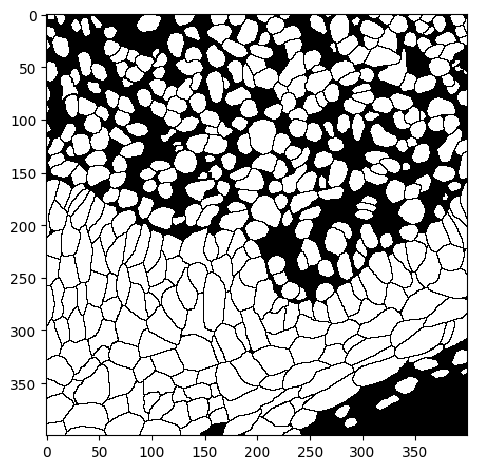

In [13]:
imshow(mask.squeeze().numpy(), cmap="gray")

In [14]:
sam_output = model(image.unsqueeze(0).to(device))

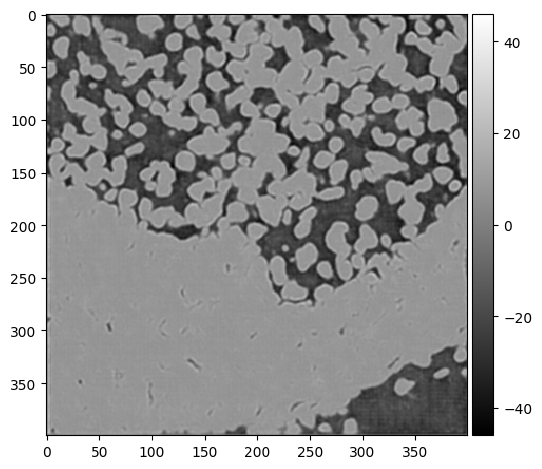

In [15]:
imshow(sam_output.squeeze().detach().cpu().numpy(), cmap="gray")

In [25]:
scaled_tensor = (sam_output - torch.min(sam_output)) * (1.0 / (torch.max(sam_output) - torch.min(sam_output)))

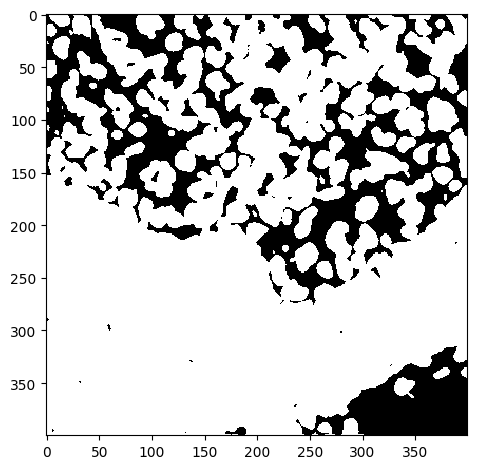

In [28]:
imshow(torch.round(scaled_tensor).detach().cpu().numpy().squeeze(), cmap='gray')